In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

In [30]:
train_file_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv' 
validation_file_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'  

In [31]:
df_train = pd.read_csv(train_file_path)
df_validation = pd.read_csv(validation_file_path)

In [32]:
#display head of df
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [33]:
df_validation.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [34]:
#adding header
df_train.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
df_validation.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']

In [35]:
df_train.head()

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [36]:
df_validation.head()

,tweet_id,entity,sentiment,tweet_content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


**EDA**

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [38]:
df_train.isnull().sum()

tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [39]:
df_train = df_train.dropna()

In [40]:
df_train.isnull().sum()

tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64

In [41]:
df_validation.isnull().sum()

tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64

In [42]:
def analyze_dataset(df, dataset_name):
    print(f"Analyse of: {dataset_name}")
    
    # Sentiment values
    sentiment_counts = df['sentiment'].value_counts()
    print(sentiment_counts)
    
    # Visualization of sentiment distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df, palette='viridis', order=sentiment_counts.index)
    plt.title(f'Distribution of sentiment classes ({dataset_name})')
    plt.ylabel('Sentiment count')
    plt.xlabel('Sentiment')
    plt.show()

Analyse of: Train
sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


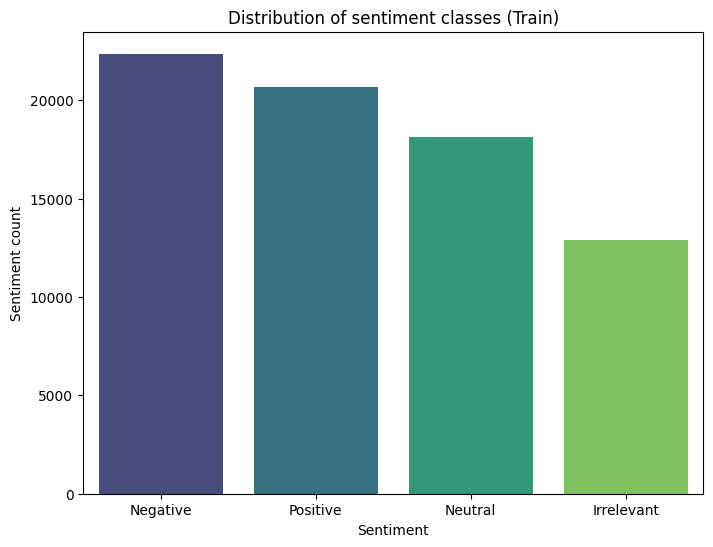

In [43]:
#Analysis for the training dataset
analyze_dataset(df_train, 'Train')

**DATA CLEANING**

In [44]:
def clean_tweet(tweet):
    # lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove @mention and #hashtag
    tweet = re.sub(r'@\w+|\#', '', tweet)
    
    # remove special characters, numbers and punctuations
    tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet)
    
    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
        
    return tweet

In [45]:
#clean the datas
df_train['cleaned_tweet'] = df_train['tweet_content'].apply(clean_tweet)
df_validation['cleaned_tweet'] = df_validation['tweet_content'].apply(clean_tweet)

In [46]:
#delete duplicated values
df_train = df_train.drop_duplicates(subset=['cleaned_tweet'])

In [48]:
df_train.duplicated().sum()

0

In [49]:
df_validation = df_validation.drop_duplicates(subset=['cleaned_tweet'])

In [50]:
df_validation.duplicated().sum()

0

In [52]:
print("\nOriginal and clean tweet example (Validation dataset):")
print(f"Original: {df_validation['tweet_content'].iloc[0]}")
print(f"Clean: {df_validation['cleaned_tweet'].iloc[0]}")


Original and clean tweet example (Validation dataset):
Original: BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
Clean: bbc news amazon boss jeff bezos rejects claims company acted like a drug dealer bbccouknewsavbusine


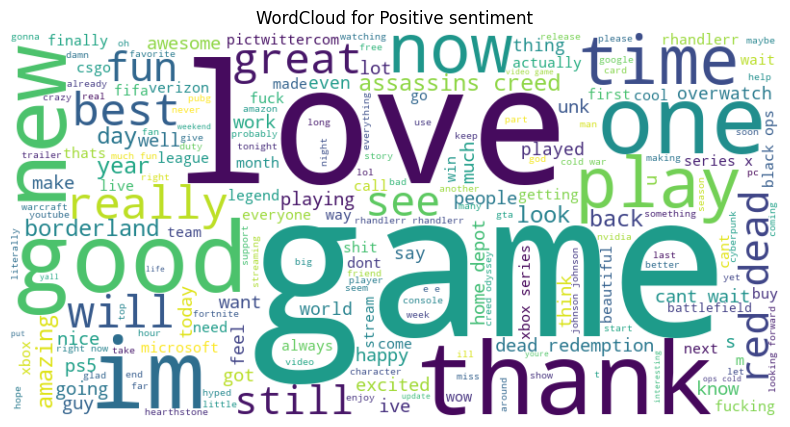

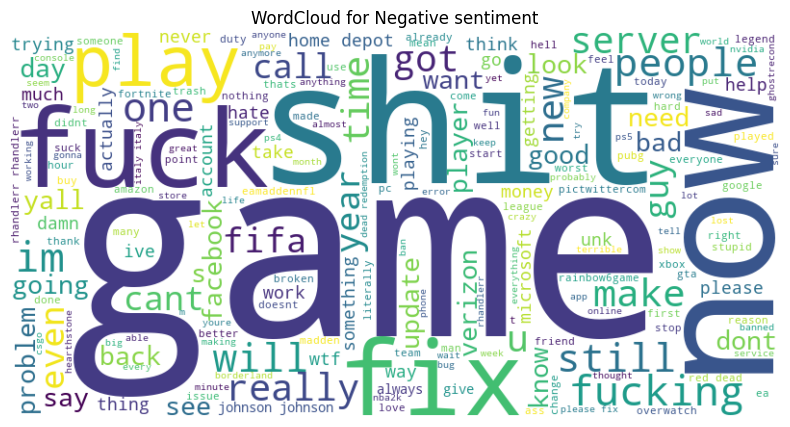

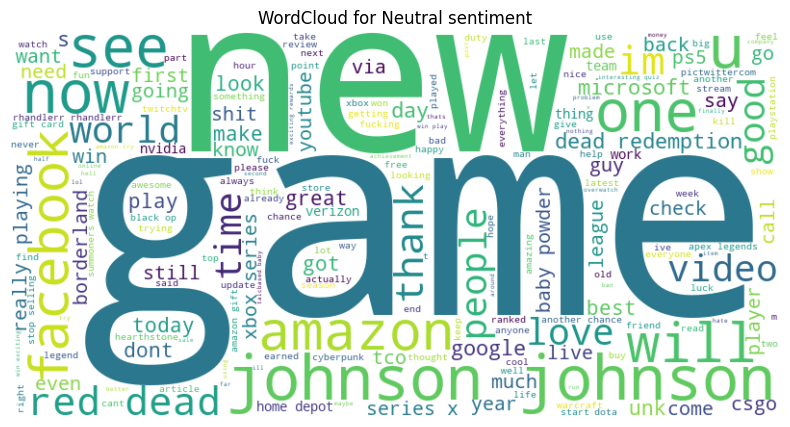

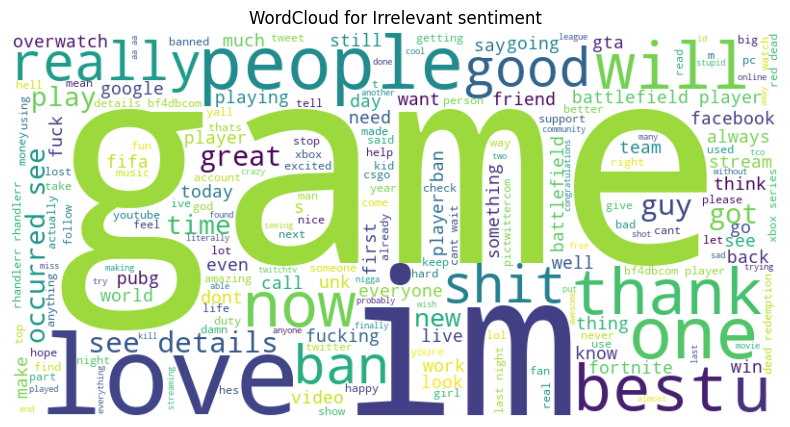

In [65]:
#word cloud for each sentiment
from wordcloud import WordCloud

def plot_wordcloud(sentiment):
    text = ' '.join(df_train[df_train['sentiment'] == sentiment]['cleaned_tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {sentiment} sentiment')
    plt.show()

plot_wordcloud('Positive')
plot_wordcloud('Negative')
plot_wordcloud('Neutral')
plot_wordcloud('Irrelevant')

**DATA PREPROCESSING / MODEL**

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
#data split
X_train = df_train.iloc[:, 3].fillna('').astype(str).values
y_train = df_train.iloc[:, 2].values

X_val = df_validation.iloc[:, 3].fillna('').astype(str).values 
y_val = df_validation.iloc[:, 2].values

In [56]:
#Label Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [57]:
#Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [58]:
#converts tests to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [59]:
# Maximum Length in sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [60]:
train_dataset = TensorDataset(torch.tensor(X_train_pad, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_pad, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [66]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Pegando a última saída da LSTM
        out = self.fc(lstm_out)
        return out

In [67]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

In [68]:
model = LSTMClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.to(device)

LSTMClassifier(
  (embedding): Embedding(10000, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [78]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3, min_delta=0.001):
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)  
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(outputs.detach())
            all_train_labels.append(labels.detach())

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_preds.append(outputs)
                all_val_labels.append(labels)

        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Atualizando as métricas ao final de cada época
        metrics_callback.update_metrics(
            epoch,
            all_train_labels.cpu().numpy(),
            all_train_preds.cpu(),
            all_val_labels.cpu().numpy(),
            all_val_preds.cpu(),
            train_loss / len(train_loader),
            val_loss / len(val_loader)
        )

        # Verificar Early Stopping com base no val_loss
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Retornando as métricas ao final do treinamento para plotar
    return metrics_callback

In [77]:
class MetricsCallback:
    def __init__(self):
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_loss = []
        self.val_loss = []

    def update_metrics(self, epoch, y_true_train, y_pred_train, y_true_val, y_pred_val, train_loss, val_loss):
        y_pred_train = torch.argmax(y_pred_train, dim=1).cpu().numpy()
        y_pred_val = torch.argmax(y_pred_val, dim=1).cpu().numpy()

        # Calculando as métricas para o conjunto de treino
        train_acc = (y_true_train == y_pred_train).mean()
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted')

        # Calculando as métricas para o conjunto de validação
        val_acc = (y_true_val == y_pred_val).mean()
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
        val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
        val_recall = recall_score(y_true_val, y_pred_val, average='weighted')

        # Armazenando as métricas e a perda
        self.train_accuracy.append(train_acc)
        self.val_accuracy.append(val_acc)
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Exibindo as métricas no final de cada época
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

In [79]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # Se for a primeira época, define o melhor loss
        if self.best_loss is None:
            self.best_loss = val_loss
        # Verifica se a melhora em val_loss é significativa
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        # Se o val_loss melhorar, reseta o contador
        else:
            self.best_loss = val_loss
            self.counter = 0

In [81]:
from sklearn.metrics import f1_score, precision_score, recall_score
metrics_callback = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)

Epoch 1 - Train Loss: 0.7408, Val Loss: 0.5375
Train Acc: 0.7153, Train F1: 0.7100, Train Precision: 0.7097, Train Recall: 0.7153
Val Acc: 0.8193, Val F1: 0.8188, Val Precision: 0.8204, Val Recall: 0.8193
Epoch 2 - Train Loss: 0.5148, Val Loss: 0.3833
Train Acc: 0.8132, Train F1: 0.8120, Train Precision: 0.8124, Train Recall: 0.8132
Val Acc: 0.8906, Val F1: 0.8901, Val Precision: 0.8902, Val Recall: 0.8906
Epoch 3 - Train Loss: 0.3614, Val Loss: 0.3125
Train Acc: 0.8746, Train F1: 0.8741, Train Precision: 0.8744, Train Recall: 0.8746
Val Acc: 0.9076, Val F1: 0.9076, Val Precision: 0.9081, Val Recall: 0.9076
Epoch 4 - Train Loss: 0.2581, Val Loss: 0.2947
Train Acc: 0.9130, Train F1: 0.9128, Train Precision: 0.9129, Train Recall: 0.9130
Val Acc: 0.9197, Val F1: 0.9200, Val Precision: 0.9217, Val Recall: 0.9197
Epoch 5 - Train Loss: 0.1936, Val Loss: 0.2734
Train Acc: 0.9352, Train F1: 0.9351, Train Precision: 0.9352, Train Recall: 0.9352
Val Acc: 0.9257, Val F1: 0.9255, Val Precision: 0.

In [82]:
def plot_metrics(metrics_callback):
    epochs = range(1, len(metrics_callback.train_accuracy) + 1)

    plt.figure(figsize=(12, 10))
    
    # Plotando a acurácia
    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics_callback.train_accuracy, label='Train Accuracy')
    plt.plot(epochs, metrics_callback.val_accuracy, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotando o F1-Score
    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics_callback.train_f1, label='Train F1-Score')
    plt.plot(epochs, metrics_callback.val_f1, label='Val F1-Score')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotando a precisão
    plt.subplot(2, 3, 3)
    plt.plot(epochs, metrics_callback.train_precision, label='Train Precision')
    plt.plot(epochs, metrics_callback.val_precision, label='Val Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotando o recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics_callback.train_recall, label='Train Recall')
    plt.plot(epochs, metrics_callback.val_recall, label='Val Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plotando a perda (loss)
    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics_callback.train_loss, label='Train Loss')
    plt.plot(epochs, metrics_callback.val_loss, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

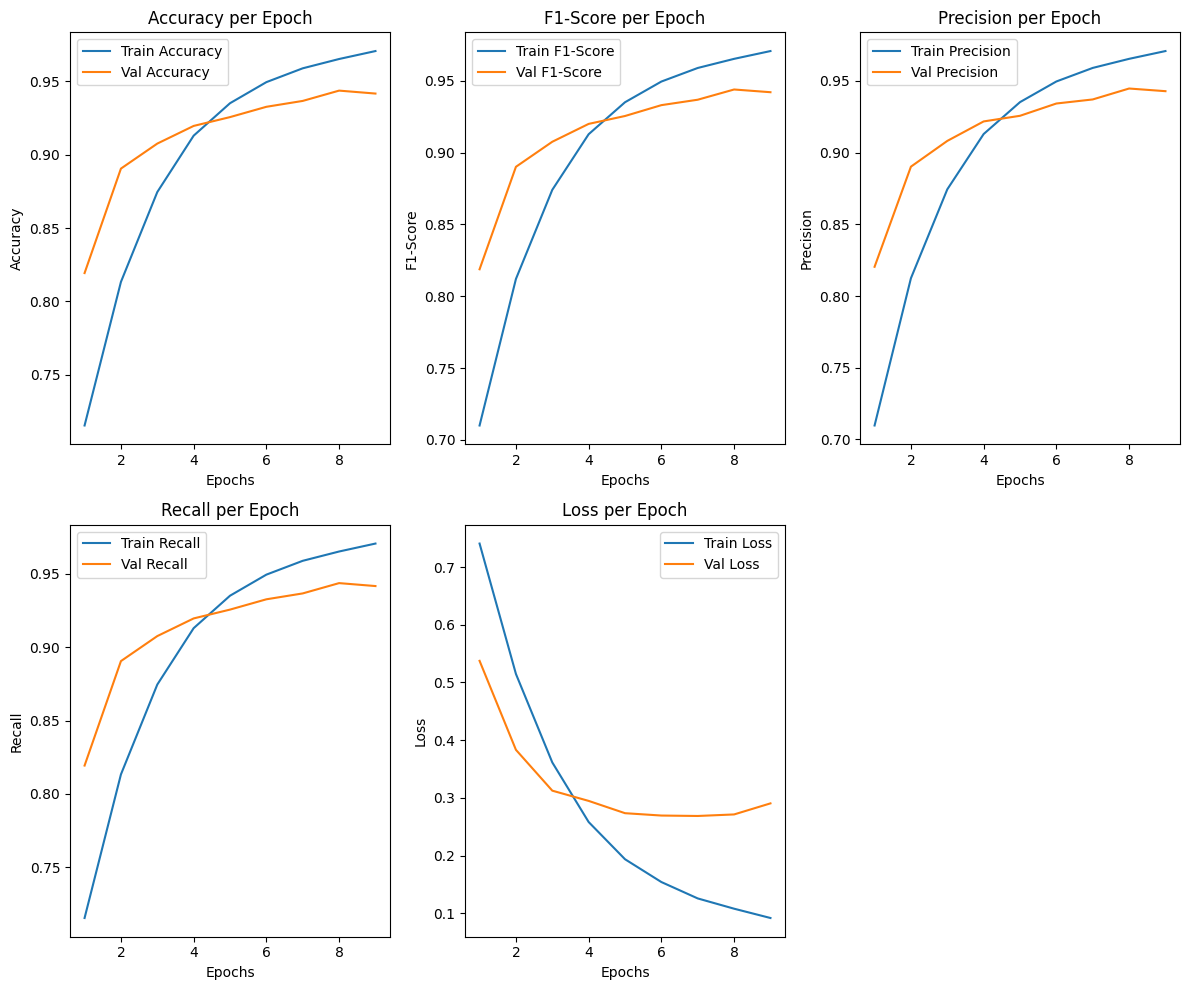

In [83]:
plot_metrics(metrics_callback)

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_val_preds.append(outputs)
        all_val_labels.append(labels)

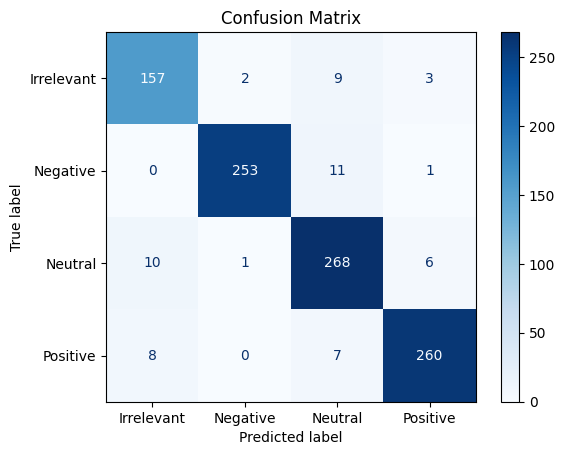

In [89]:
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# Converting predictions to labels
y_pred_val = torch.argmax(all_val_preds, dim=1).cpu().numpy()
y_true_val = all_val_labels.cpu().numpy()

# Calculating the confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()